In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 12)


import geopandas as gpd
import pandas as pd
import rasterio as rio

from rasterio import plot as rio_plot

# HRSL Uganda

**Note: This data is all compressed on S3 so you will need to unzip both the GADM data (shapefiles of political boundaries) and the HRSL data (raster grids of population) before running this notebook.**

 - Load Admin2 boundaries from GADM
 - Select Rawanda as a test case
 - plot the boundaries
 - plot all the data
 - Calculate the sum per admin area using `zonal_stats`
 - plot the calculated populations
 

### Load GADM boundaries

In [2]:
boundaries = gpd.read_file(str(Path('../data/external/gadm28_levels.shp/gadm28_adm2.shp')))

In [3]:
admin_2 = boundaries[boundaries.ISO == 'UGA']

In [4]:
def clean_uga_districts(series):
    ss = (series.str.strip()
                    .str.lower()
                    .replace({'ssembabule': 'sembabule'}))
    
    return ss

admin_2.NAME_2 = clean_uga_districts(admin_2.NAME_2)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


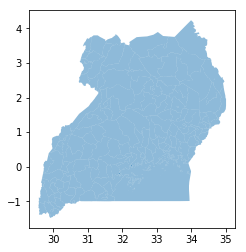

In [5]:
admin_2.plot(alpha=0.5)
figsize(12, 12)

### Load HRSL data

In [6]:
hrsl_path = str(Path("../data/external/HRSL/uga/hrsl_uga.tif"))
rst = rio.open(hrsl_path)

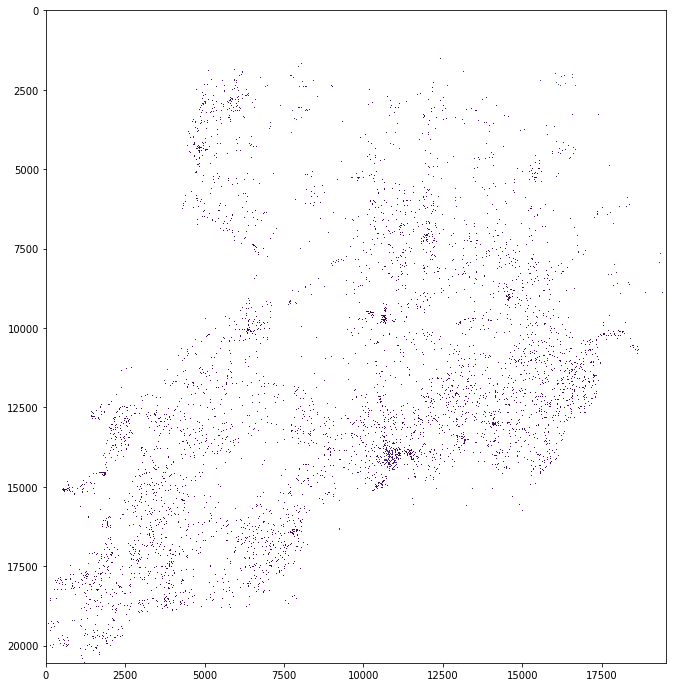

In [7]:
rio_plot.show(rst, cmap=plt.cm.viridis)

### Calculate sum of population for each admin area

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

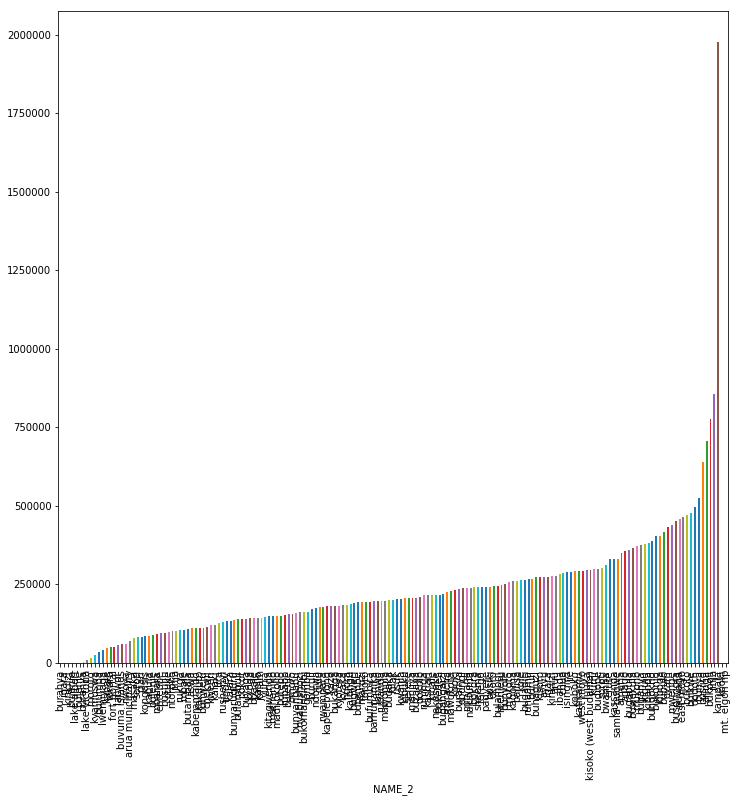

In [8]:
import rasterstats as rs

pop_list = rs.zonal_stats(admin_2, hrsl_path, stats='sum')
admin_2['hrsl_pop'] = [x['sum'] for x in pop_list]

(admin_2.set_index('NAME_2')
        .hrsl_pop
        .sort_values()
        .plot(kind='bar'))

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


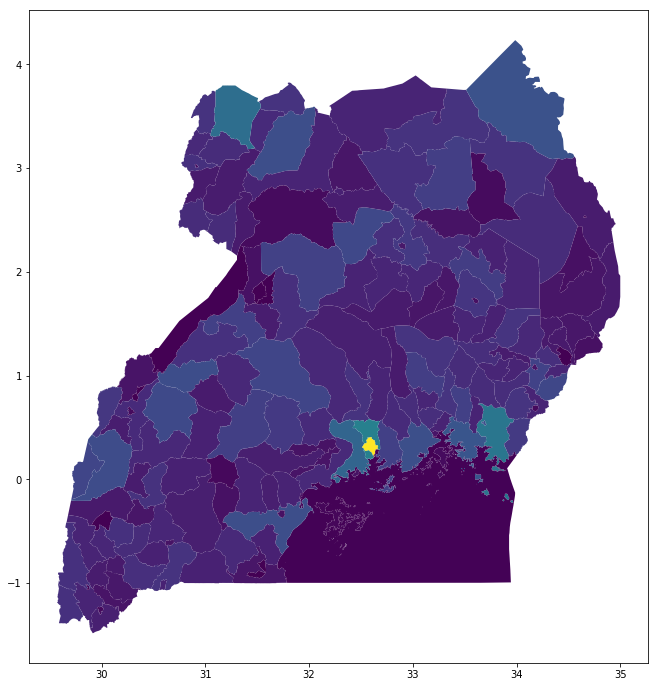

In [9]:
admin_2.plot(column='hrsl_pop')

# Load World Pop Births

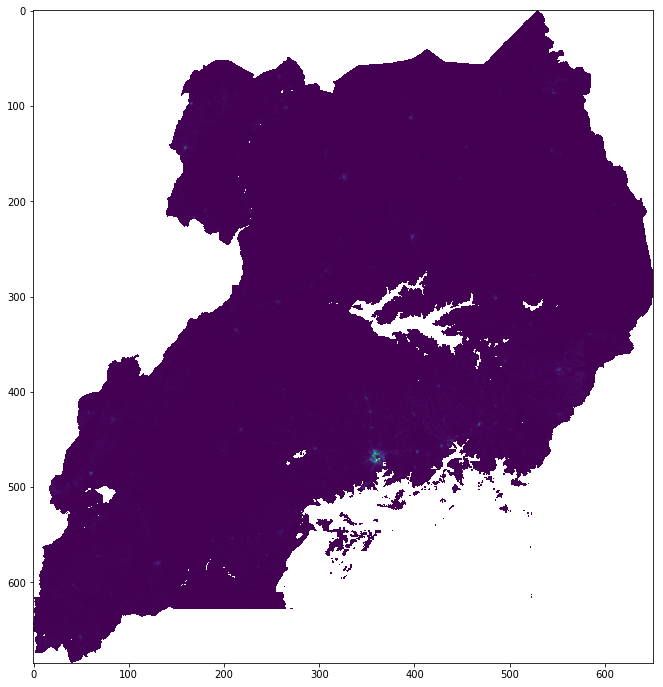

In [10]:
# worldpop_births_path = str(Path("../data/external/WorldPop/Rwanda 1km births/RWA_births_pp_v2_2015.tif"))
worldpop_births_path = str(Path("../data/external/WorldPop/Uganda 1km births/UGA_births_pp_v2_2015.tif"))


rst = rio.open(worldpop_births_path)
rio_plot.show(rst, cmap=plt.cm.viridis)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is try

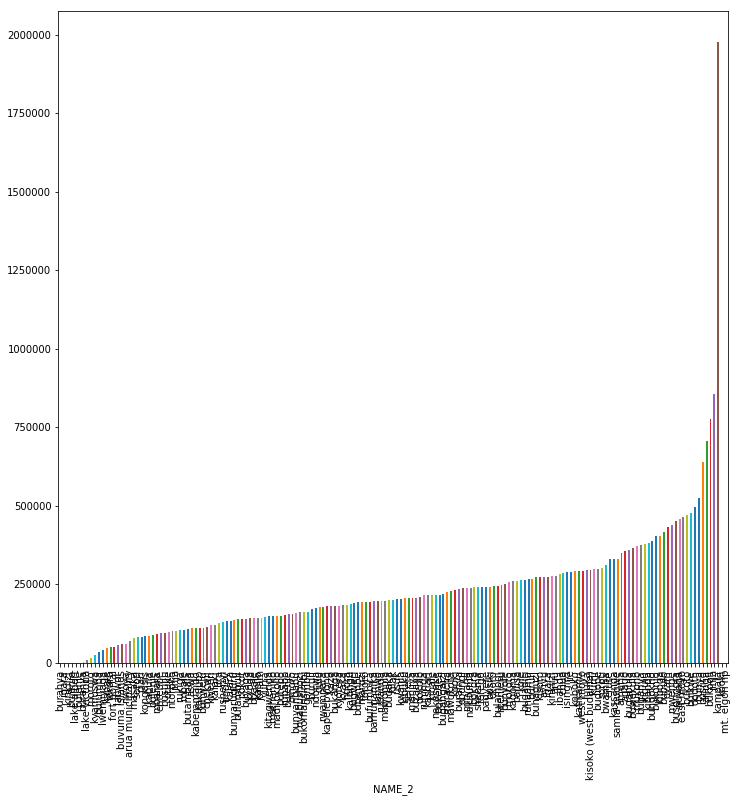

In [11]:
pop_list = rs.zonal_stats(admin_2, worldpop_births_path, stats='sum')
admin_2['worldpop_births'] = [x['sum'] for x in pop_list]

(admin_2.set_index('NAME_2')
            .hrsl_pop
            .sort_values()
            .plot(kind='bar'))

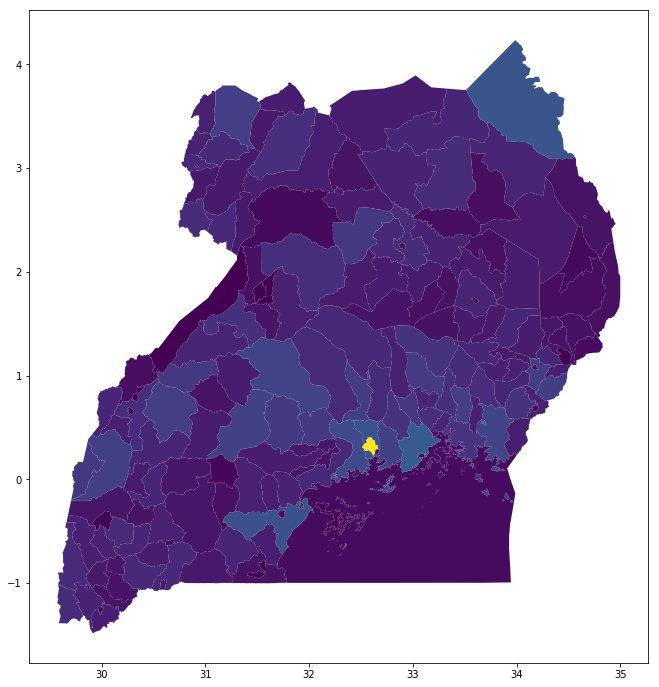

In [12]:
admin_2.plot(column='worldpop_births')

### Load WHO data

In [13]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)

who_df = who_df[who_df['Iso Code'] == 'UGA']
who_df.head(2)

who_df.Admin2 = clean_uga_districts(who_df.Admin2)

### Estimate population with WHO data

 - Get denominator for each region
 - Multiply by the crude birth rate (https://data.worldbank.org/indicator/SP.DYN.CBRT.IN)
 - Remove " Distrct" from names
 - Plot estimates

In [14]:
who_births = (who_df[who_df.DenomType == 1]
                         .groupby('Admin2')
                         .Denominator
                         .first())

who_pops = who_births.multiply(1000 / 42.63)  # crude birth rate for uganda

# index to names that will match admin2
# # who_births.index = who_births.index.str.strip(" District")
who_births.name = 'who_reported_births'

# who_rwa_pops.index = who_rwa_pops.index.str.strip(" District")
who_pops.name = 'who_pop_estimate'

who_pops

Admin2
abim             1.382829e+05
adjumani         2.608961e+05
agago            2.685667e+05
alebtong         2.735632e+05
amolatar         1.797091e+05
amudat           1.308937e+05
amuria           3.295567e+05
amuru            2.240206e+05
apac             4.475252e+05
arua             9.403003e+05
budaka           2.530143e+05
bududa           2.611072e+05
bugiri           4.621628e+05
buhweju          1.460005e+05
buikwe           5.014075e+05
bukedea          2.519822e+05
bukomansimbi     1.746892e+05
bukwo            1.120807e+05
bulambuli        2.184612e+05
buliisa          1.414028e+05
bundibugyo       2.703026e+05
bushenyi         2.726249e+05
busia            3.906639e+05
butaleja         2.987098e+05
butambala        1.177340e+05
buvuma           1.155524e+05
buyende          4.006099e+05
dokolo           2.205724e+05
gomba            1.874502e+05
gulu             5.287122e+05
                     ...     
mpigi            2.988975e+05
mubende          8.421065e+05
muk

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


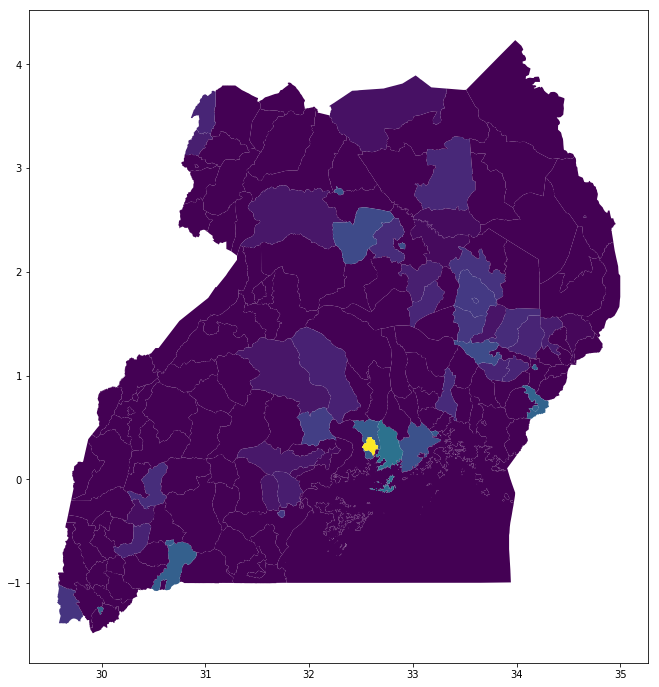

In [15]:
(admin_2.set_index('NAME_2')
            .join(who_pops)
            .plot(column='who_pop_estimate'))

In [ ]:
diff_data = (admin_2.set_index('NAME_2')
                        .join(who_pops)
                        .assign(who_diff=lambda x: x.who_pop_estimate - x.hrsl_pop))


diff_data.plot(column='who_diff',
               cmap=plt.cm.PRGn_r,
               legend=True,
               vmin=-diff_data.who_diff.abs().max(),
               vmax=diff_data.who_diff.abs().max())

In [ ]:
diff_data2 = (admin_2.set_index('NAME_2')
                        .join(who_births)
                        .assign(worldpop_diff=lambda x: x.who_reported_births - x.worldpop_births))


diff_data2.plot(column='worldpop_diff',
               cmap=plt.cm.PRGn_r,
               legend=True,
               vmin=-diff_data2.worldpop_diff.abs().max(),
               vmax=diff_data2.worldpop_diff.abs().max())
